In [2]:
# Use full screen width in Jupyter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Imports

import tensorflow as tf
import keras_ocr
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
%matplotlib inline
print("Tensorflow version: ", tf.__version__)

# Load model

import os
from object_detection.utils import label_map_util #setup above
from object_detection.utils import visualization_utils as viz_utils #to overlay bounding boxes
from object_detection.builders import model_builder #build model from checkpoint and config file

# Call number

import pycallnumber as pycn

# Setup paths

WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CUSTOM_MODEL_NAME = '/my_ssd_mobnet3'
CONFIG_PATH = MODEL_PATH+CUSTOM_MODEL_NAME+'/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+CUSTOM_MODEL_NAME
FINE_TUNED_CHECKPOINT = PRETRAINED_MODEL_PATH+'/efficientdet_d1_coco17_tpu-32/checkpoint/ckpt-0'

Tensorflow version:  2.6.0


In [84]:
# Create label map

# call number is either a sticker or printed
labels = [{'name':'sticker', 'id':1}, {'name':'printed', 'id':2}]

with open(ANNOTATION_PATH + '/label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# Create TF records (for training only)

In [85]:
'''
in `generate_tfrecord.py`, change these 2 lines to one:

#label_map = label_map_util.load_labelmap(args.labels_path)
#label_map_dict = label_map_util.get_label_map_dict(label_map)
label_map_dict = label_map_util.get_label_map_dict(args.labels_path)
'''

!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# Get Model (MobileNetSSD or EfficientDet)

In [ ]:
# check out other models here for a more accurate one: 
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
!cd Tensorflow && git clone https://github.com/tensorflow/models

In [ ]:
#wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz')
#!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}
#!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

In [86]:
# 4. Copy Model Config to Training Folder

# copying Tensorflow > workspace > pre-trained-models > pipeline.config

try:
    os.makedirs("Tensorflow/workspace/models/"+CUSTOM_MODEL_NAME)
except:
    print('Error - directory {} already exists.'.format(CUSTOM_MODEL_NAME))
#!mkdir {'\Tensorflow\workspace\models\\'+CUSTOM_MODEL_NAME}
try:
    # copy the `pipeline.config` file from the pretrained model (here it's efficientdet_d5 at 1280x1280)
    #!cp {PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}
    !cp {PRETRAINED_MODEL_PATH+'/efficientdet_d1_coco17_tpu-32/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}
except:
    print('Error - unable to copy pipeline.config file.')

Error - directory /my_ssd_mobnet3 already exists.


# 5. Update Config For Transfer Learning

In [87]:
# CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet2/pipeline.config'
# CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet2/'

CONFIG_PATH = MODEL_PATH + '/' + CUSTOM_MODEL_NAME + '/pipeline.config'

# on errors, replaced tf.gfile.GFile with tf.io.gfile.GFile
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
print(CONFIG_PATH)
print(config)

'''
python Tensorflow/models/research/object_detection/model_main_tf2.py 
--model_dir=Tensorflow/workspace/models/my_ssd_mobnet 
--pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config 
--num_train_steps=5000

python Tensorflow/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config \
    --num_train_steps=5001 \
    --model_dir=Tensorflow/workspace/models/my_ssd_mobnet \
    --alsologtostderr
'''

Tensorflow/workspace/models//my_ssd_mobnet3/pipeline.config
{'model': ssd {
  num_classes: 90
  image_resizer {
    keep_aspect_ratio_resizer {
      min_dimension: 640
      max_dimension: 640
      pad_to_max_dimension: true
    }
  }
  feature_extractor {
    type: "ssd_efficientnet-b1_bifpn_keras"
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 3.9999998989515007e-05
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: SWISH
      batch_norm {
        decay: 0.9900000095367432
        scale: true
        epsilon: 0.0010000000474974513
      }
      force_use_bias: true
    }
    bifpn {
      min_level: 3
      max_level: 7
      num_iterations: 4
      num_filters: 88
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 1.0
      x_scale: 1.0
      height_scale: 1.0
      width_scale: 1.0
    }
  }
  matcher {
  

'\npython Tensorflow/models/research/object_detection/model_main_tf2.py \n--model_dir=Tensorflow/workspace/models/my_ssd_mobnet \n--pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config \n--num_train_steps=5000\n\npython Tensorflow/models/research/object_detection/model_main_tf2.py     --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config     --num_train_steps=5001     --model_dir=Tensorflow/workspace/models/my_ssd_mobnet     --alsologtostderr\n'

In [88]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [89]:
# edit the pipeline file

# num_classes is how many labels we have above (sticker and printed)
pipeline_config.model.ssd.num_classes = 2
pipeline_config.train_config.batch_size = 4
# pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint = FINE_TUNED_CHECKPOINT
#pipeline_config.train_config.fine_tune_checkpoint = 'Tensorflow/workspace/models/my_ssd_mobnet/ckpt-5'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [90]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# Train Model

In [91]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=5001""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))


'''
python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=5500

'''

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models//my_ssd_mobnet3 --pipeline_config_path=Tensorflow/workspace/models//my_ssd_mobnet3/pipeline.config --num_train_steps=5001


'\npython Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=5500\n\n'

In [56]:
!python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=500

2021-12-05 03:05:49.535063: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
W1205 03:05:49.536229 4441693696 cross_device_ops.py:1387] There are non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
I1205 03:05:49.552850 4441693696 mirrored_strategy.py:369] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 500
I1205 03:05:49.673447 4441693696 config_util.py:552] Maybe overwriting train_steps: 500
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1205 03:05:49.673596 4441693696 config_util.py:552] Maybe overwriting use_bfl

# Load Model From Trained Checkpoint

In [13]:
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet3/'
CONFIG_PATH = MODEL_PATH + '/my_ssd_mobnet3/pipeline.config'

print('CHECKPOINT_PATH to load trained model: ', CHECKPOINT_PATH)
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-6')).expect_partial()
# {1: {'id': 1, 'name': 'sticker'}, 2: {'id': 2, 'name': 'printed'}}
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image) # resize to 320x320
    prediction_dict = detection_model.predict(image, shapes) # use detection model to predict
    detections = detection_model.postprocess(prediction_dict, shapes) # postprocess
    return detections # return image

#ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-51')).expect_partial()

CHECKPOINT_PATH to load trained model:  Tensorflow/workspace/models/my_ssd_mobnet3/


# Verify Model is Working

In [4]:
def getBoundingBoxes(MIN_THRESH, detections, width, height):

    '''
    Returns non-normalized bounding box locations as a dict for the current frame passed to `detectFrame`.
    
    Parameters:
        MIN_THRESH(float): Thresold value for detection used in `detectFrame`
        detections(dict): normalized bounding box locations (e.g. 'x1': 0.68594307) 
        width(float): frame width parsed in `detectFrame`
        height(float): frame height parsed in `detectFrame`
    Returns:
        (dict): Non-normalized for the current frame's bounding boxes (e.g. 'x1': 1225) 
        e.g. 
          {0: {'x1': 1225,
          'y1': 909,
          'x2': 1500,
          'y2': 1134,
          'width': 1786,
          'height': 1368,
          'category_name': 'sticker'}
           1: ...}
    '''
    
    # get normalized float coordinates for all bounding boxes
    boxes = detections['detection_boxes']
    # number of boxes in array
    max_boxes_to_draw = boxes.shape[0]
    # get scores to get a threshold
    scores = detections['detection_scores']
    # this is set as a default but feel free to adjust it to your needs
    min_score_thresh = MIN_THRESH
    
    # store bounding boxes
    boxes_dict = {}
    
    # itereate over bounding boxes in the current frame
    for i in range(min(max_boxes_to_draw, boxes.shape[0])):
        # 
        if scores is None or scores[i] > min_score_thresh:
            # boxes[i] is the box which will be drawn
            # +1 because category_index only has the keys `1` and `2`
            class_name = category_index[detections['detection_classes'][i] + 1]['name']
            #print ("This box is gonna get used", boxes[i], class_name)
            boxes_dict[i] = {'x1': int(boxes[i][1] * width), 'y1': int(boxes[i][0] * height), 
                             'x2': int(boxes[i][3] * width), 'y2': int(boxes[i][2] * height), 
                             'width': width, 'height': height,
                             'category_name': class_name}
    return boxes_dict


def detectFrame(frame):
    '''
    Returns the the annoted image, original image, and all bounding boxes.
    
    Parameters:
        frame (str): File location of image or a frame of type numpy.ndarray
    Returns:
        image_np_with_detections(numpy.ndarray): Modified image with detections
        image_np(numpy.ndarray): Original image
        detections(dict): Bounding boxes 
    '''
    
    # image detection threshold percent
    MIN_THRESH = 0.7
    if (type(frame).__module__ == 'numpy'):
        image_np = frame
    else:
        input_filename = os.path.basename(frame).split('.')[0]
        frame = cv2.imread(frame)
        image_np = np.array(frame) # convert frame to numpy array

    # convert np array to tensorflow tensor and expand_dims puts it in another array
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections # add detections back

    # detection_classes cast to int
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    

    label_id_offset = 1
    
    # need to copy because when we pass to viz_utils func below, it'll transform the array
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=100,
                min_score_thresh=MIN_THRESH,
                line_thickness=10)

    scale_percent = 100
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    #cv2.imwrite('/Users/j/downloads/cap/' + input_filename + '_OUTPUT.jpg', cv2.resize(image_np_with_detections, (width, height)))
    
    bounding_boxes = getBoundingBoxes(MIN_THRESH, detections, width, height)
    # sort the bounding boxes according to x1 coordinate so they appear in order from left-to-right
    bounding_boxes_sorted = dict(sorted(bounding_boxes.items(), key=lambda x: x[1]["x1"], reverse=False))
    
    # re-key sorted bounding boxes from 0..x
    bbox_old_keys = list(bounding_boxes_sorted.keys())
    bbox2 = bounding_boxes_sorted.copy()
    bounding_boxes_sorted_rekeyed = {}
    for new_key, val in enumerate(bbox2.items()):
        bounding_boxes_sorted_rekeyed[new_key] = val[1]
        
    return image_np_with_detections, image_np, bounding_boxes_sorted_rekeyed

In [5]:
# Source: https://stackoverflow.com/questions/41793931/plotting-images-side-by-side-using-matplotlib

def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
        
    Note:
    Only PNG file types are supported in plt.subplot because 
    the subplot only accepts two-dimensional images, 
    and since the JPG has three color channels, 
    matplotlib isn't sure which information
    to map to x & y dimensions
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()
    
def pltImShowBox(original_image, bounding_boxes, boxNumToShow):
    '''
    If we consider (0,0) as top left corner of image called `im` 
    with left-to-right as x direction and top-to-bottom as y direction. 
    and we have (x1,y1) as the top-left vertex and (x2,y2) as the bottom-right vertex 
    of a rectangle region within that image, then:

    roi = im[y1:y2, x1:x2]
    '''
    
    #print('There are {} bounding boxes available to draw.'.format(len(bounding_boxes)))
    
    if boxNumToShow > len(bounding_boxes):
        print('The box you want to show is out of range.')
        return
    
    roi = original_image[bounding_boxes[boxNumToShow]['y1']:bounding_boxes[boxNumToShow]['y2'], 
                   bounding_boxes[boxNumToShow]['x1']:bounding_boxes[boxNumToShow]['x2']]

    #plt.imshow(roi)
    return roi

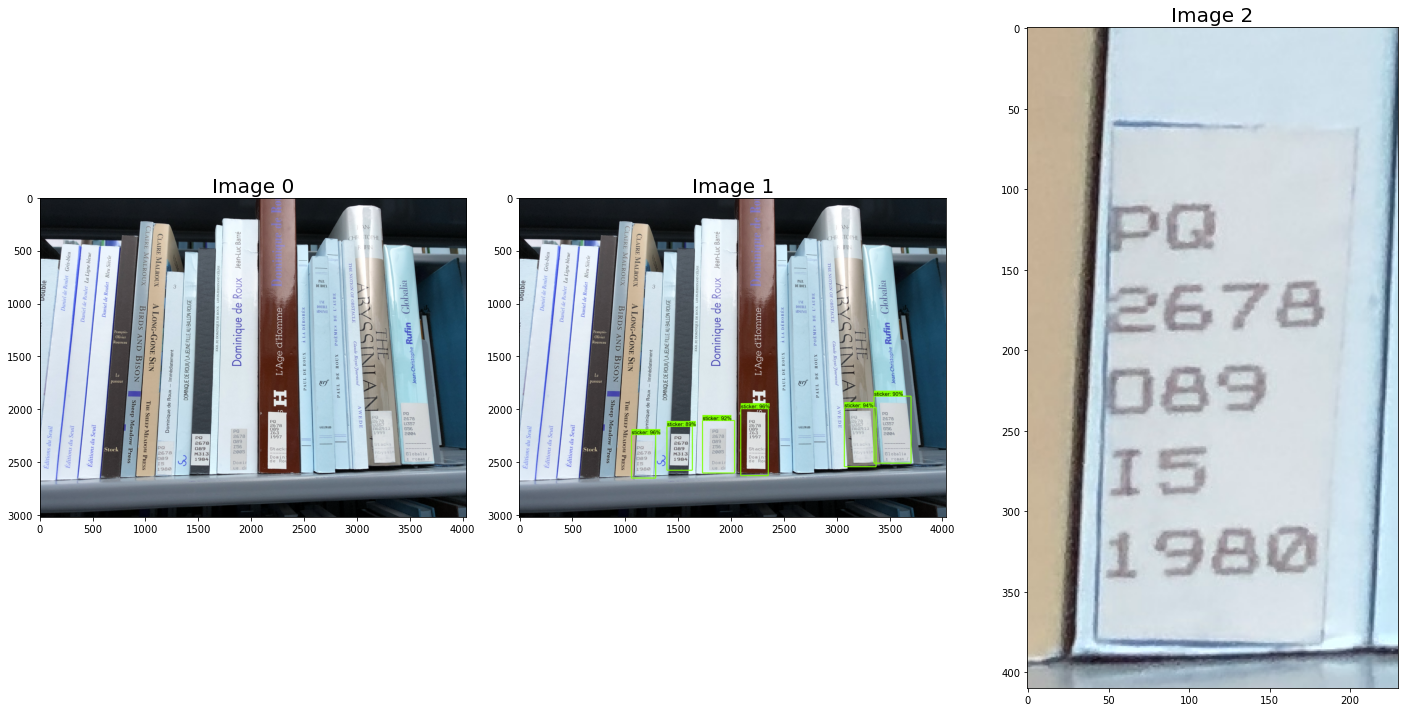

In [6]:
tf.config.run_functions_eagerly(True)
detected, original, bounding_boxes = detectFrame('../Resources/Testing/Inputs/test1.JPG')

show_image_list(list_images=[original, detected, pltImShowBox(original, bounding_boxes, 0)], 
                #list_titles=['original', 'gradx', 'grady', 'mag_binary', 'dir_binary'],
                num_cols=3,
                figsize=(20, 10),
                grid=False, # overlay a grid
                title_fontsize=20)


# Nov 16 trained on 11 epochs, 50,000 steps

This box is gonna get used [0.43133488 0.05633419 0.8166678  0.21891665] sticker
There are 1 bounding boxes available to draw.


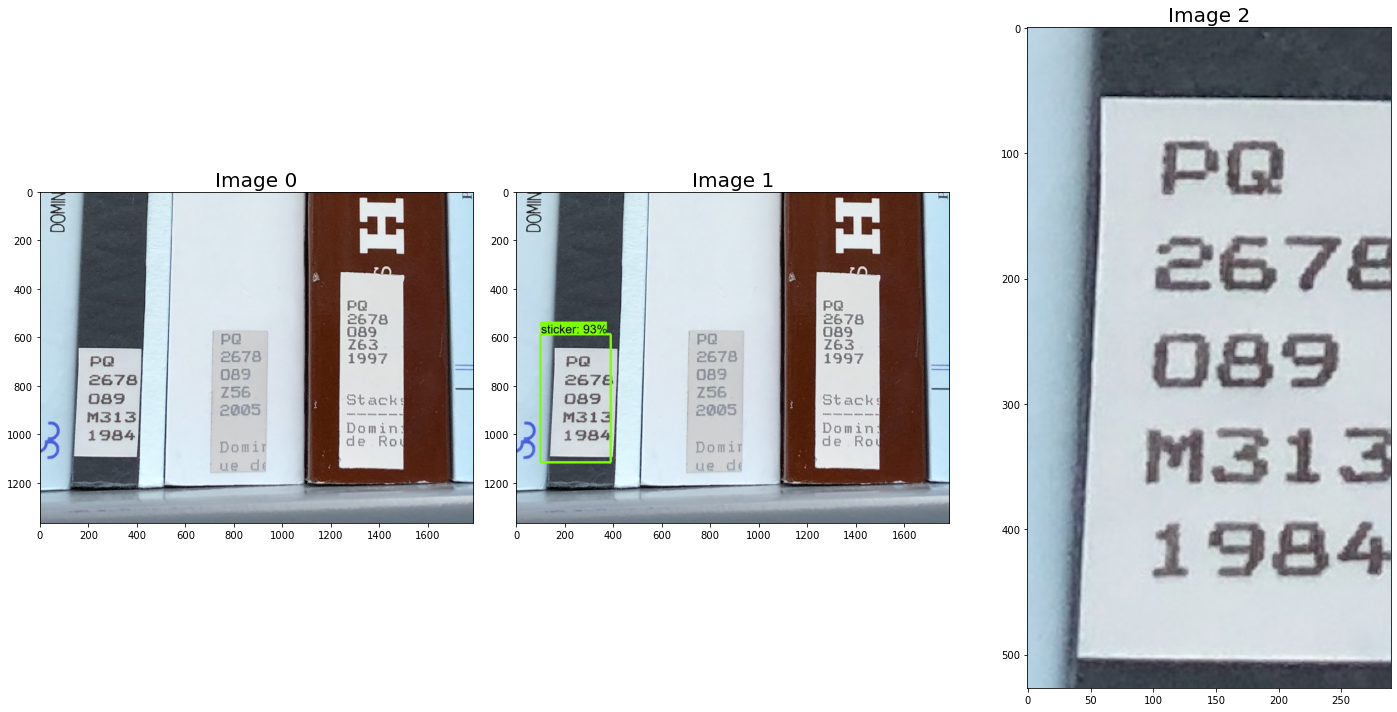

In [19]:
detected, original, bounding_boxes = detectFrame('../Resources/Testing/Inputs/test2.PNG')

show_image_list(list_images=[original, detected, pltImShowBox(original, bounding_boxes, 0)], 
                #list_titles=['original', 'gradx', 'grady', 'mag_binary', 'dir_binary'],
                num_cols=3,
                figsize=(20, 10),
                grid=False, # overlay a grid
                title_fontsize=20)

This box is gonna get used [0.65429246 0.6877277  0.87859106 0.79064023] sticker
This box is gonna get used [0.6308779  0.22241567 0.8111769  0.2837598 ] sticker
This box is gonna get used [0.7319166  0.93788505 0.920506   1.        ] sticker
This box is gonna get used [0.66136396 0.3461965  0.7928184  0.4060757 ] sticker
This box is gonna get used [0.61612374 0.53050417 0.80817497 0.60834795] printed
This box is gonna get used [0.6730521  0.4243972  0.8613713  0.49492052] printed
There are 6 bounding boxes available to draw.


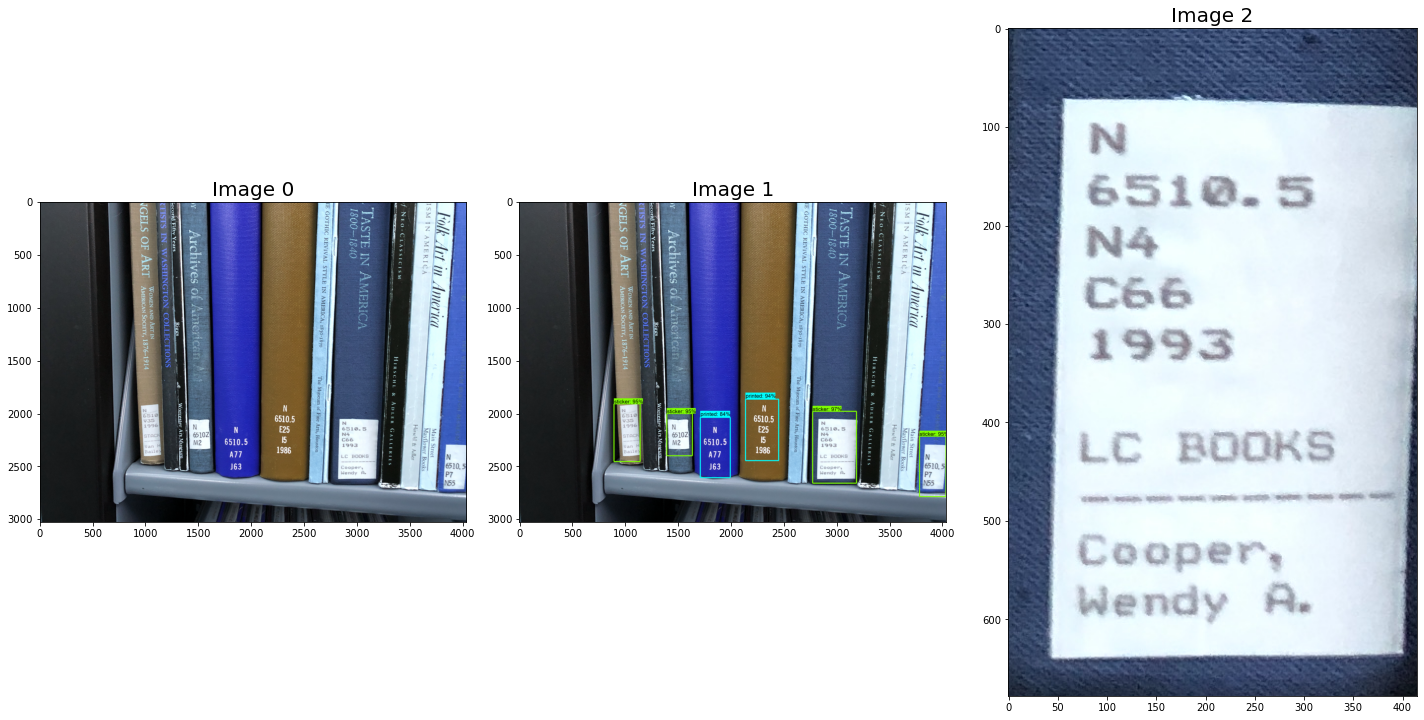

In [16]:
detected, original, bounding_boxes = detectFrame('../Resources/Testing/Inputs/test3.JPG')

show_image_list(list_images=[original, detected, pltImShowBox(original, bounding_boxes, 0)], 
                #list_titles=['original', 'gradx', 'grady', 'mag_binary', 'dir_binary'],
                num_cols=3,
                figsize=(20, 10),
                grid=False, # overlay a grid
                title_fontsize=20)

### Extracting labels from a video to train the keras-ocr detector on custom label text

In [27]:
# loop over video frames

vid = '/Users/j/Google Drive/MSD Utah/Fall 2021/Capstone/resources/Testing/Inputs/vid3.MOV'
cap = cv2.VideoCapture(vid)
print("FPS : {0}".format(cap.get(cv2.CAP_PROP_FPS)))
print("Total frames: {}".format(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))

count = 0

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        cv2.imwrite('/Users/j/Google Drive/MSD Utah/Fall 2021/Capstone/resources/Testing/Outputs/vid3_frame{:d}.png'.format(count), frame)
        # detectFrame('/users/j/downloads/cap/frame' + str(count) + '.png')
        count += 30 # i.e. at 60 fps, count += 30 captures 1 frame per second
        cap.set(cv2.CAP_PROP_POS_FRAMES, count)
    else:
        cap.release()
        break

FPS : 60.0
Total frames: 667


In [37]:
# rename all files in directory to word_1...word_x
pic_dir = '/Users/j/Pictures/Screenshots/153_onwards/'

for count, filename in enumerate(os.listdir(pic_dir)):
    new_filename = f"word_{str(count+153)}.png"
    current_filename = f"{pic_dir}/{filename}"  # foldername/filename, if .py file is outside folder
    destination_filepath = f"{pic_dir}/{new_filename}"

    # rename() function will
    # rename all the files
    os.rename(current_filename, destination_filepath)

## VIDEO EXPERIMENTING

In [ ]:
os.listdir('../Resources/outputs/frame_capture')

In [213]:
import cv2
import os

slowCloseVid = '/Users/j/downloads/cap/vid3.MOV'
cap = cv2.VideoCapture(slowCloseVid)
print("FPS : {0}".format(cap.get(cv2.CAP_PROP_FPS)))
print("Total frames: {}".format(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))

count = 0

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        cv2.imwrite('/users/j/downloads/cap/frame{:d}.jpg'.format(count), frame)
        detectFrame('/users/j/downloads/cap/frame' + str(count) + '.jpg')
        count += 120 # i.e. at 30 fps, this advances one second
        cap.set(cv2.CAP_PROP_POS_FRAMES, count)
    else:
        cap.release()
        break

FPS : 60.0
Total frames: 667
This box is gonna get used [0.66497076 0.68594307 0.8293694  0.84025985] sticker
This box is gonna get used [0.7712602  0.08813953 0.89909846 0.22972807] sticker
This box is gonna get used [0.66497076 0.68594307 0.8293694  0.84025985] sticker
This box is gonna get used [0.7712602  0.08813953 0.89909846 0.22972807] sticker
This box is gonna get used [0.66497076 0.68594307 0.8293694  0.84025985] sticker
This box is gonna get used [0.7712602  0.08813953 0.89909846 0.22972807] sticker
This box is gonna get used [0.66497076 0.68594307 0.8293694  0.84025985] sticker
This box is gonna get used [0.7712602  0.08813953 0.89909846 0.22972807] sticker
This box is gonna get used [0.66497076 0.68594307 0.8293694  0.84025985] sticker
This box is gonna get used [0.7712602  0.08813953 0.89909846 0.22972807] sticker
This box is gonna get used [0.66497076 0.68594307 0.8293694  0.84025985] sticker
This box is gonna get used [0.7712602  0.08813953 0.89909846 0.22972807] sticker

### XML to CSV Utility

In [ ]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


# taken from https://github.com/datitran/raccoon_dataset

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main(): # this is the part we change to work with our setup
    for directory in ['train','test']:
        image_path = os.path.join(os.getcwd(), 'images/{}'.format(directory))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv('data/{}_labels.csv'.format(directory), index=None)
        print('Successfully converted xml to csv.')


main()

### OCR Recognition

There are 6 bounding boxes available to draw.


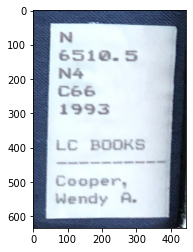

In [7]:
roi = pltImShowBox(original, bounding_boxes, 0)
cv2.imwrite('/users/j/downloads/cap/imBox1.jpg', roi)
plt.imshow(roi)

In [8]:
# !pip install keras-ocr
# https://github.com/clovaai/CRAFT-pytorch

import keras_ocr
from matplotlib import pyplot as plt
import numpy as np

# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /Users/j/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/j/.keras-ocr/crnn_kurapan.h5


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


(7,)


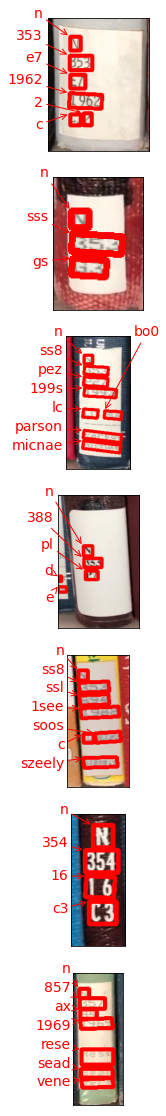

In [10]:
# List of three example images
spine_labels = ['/users/j/downloads/cap/spine_labels/1.png',
               '/users/j/downloads/cap/spine_labels/2.png',
               '/users/j/downloads/cap/spine_labels/3.png',
               '/users/j/downloads/cap/spine_labels/4.png',
               '/users/j/downloads/cap/spine_labels/5.png',
               '/users/j/downloads/cap/spine_labels/6.png',
               '/users/j/downloads/cap/spine_labels/7.png',] 
images = [keras_ocr.tools.read(img) for img in spine_labels]

#Print shape...
print(np.shape(images))

# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
prediction_groups = pipeline.recognize(images)

# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

### Other Methods

In [ ]:
# To HTML

import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(12,5))

def grab_frame(cap):
    ret,frame = cap.read()
    return cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

#Initiate the two cameras
cap1 = cv2.VideoCapture(slowCloseVid)
#cap2 = cv2.VideoCapture(slowCloseVid)

#create two subplots
ax1 = plt.subplot(1,2,1)
#ax2 = plt.subplot(1,2,2)

#create two image plots
im1 = ax1.imshow(grab_frame(cap1))
#im2 = ax2.imshow(grab_frame(cap2))

def update(i):
    im1.set_data(grab_frame(cap1))
    #im2.set_data(grab_frame(cap2))
    
anim = FuncAnimation(fig, update, frames=100, interval=20)
from IPython.display import HTML
HTML(anim.to_html5_video())

In [ ]:
# Old detectFrame function
#ret, frame = cap.read() # get frame from cv2.VideoCapture
frame = cv2.imread('../Resources/Testing/Inputs/second_test.png')
image_np = np.array(frame) # convert frame to numpy array

# convert np array to tensorflow tensor and expand_dims puts it in another array
# because tensorflow expects multiple images to come through (we're just passing one)
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

# get number of detections
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections # add detections back

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
# need to copy because when we pass to viz_utils func below, it'll transform the array!
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections, # image_np_with_detections is the raw webcam image!
            detechttp://localhost:8888/notebooks/MobileNetSSD_Book_Tool.ipynb#tions['detection_boxes'],
            detections['detection_classes'].astype("int32")+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=100,
            min_score_thresh=.9,
            agnostic_mode=False)

scale_percent = 100
width = int(frame.shape[1] * scale_percent / 100)
height = int(frame.shape[0] * scale_percent / 100)
cv2.imwrite('../Resources/Testing/Outputs/first_test_OUTPUT.jpg', cv2.resize(image_np_with_detections, (width, height)))
plt.imshow(cv2.resize(image_np_with_detections, (width, height)))
plt.show()

### Export model
* https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md#step-1-export-tflite-inference-graph

In [14]:
# Exporting EfficientDetD1 to .tflite:

!python {'../Resources/Model_Export/exporter_main_v2.py'} \
    --input_type 'image_tensor' \
    --pipeline_config_path 'Tensorflow/workspace/models/my_ssd_mobnet3/pipeline.config' \
    --trained_checkpoint_dir 'Tensorflow/workspace/models/my_ssd_mobnet3/' \
    --output_directory '../Resources/Model_Export/efficient_det_640x640/'


2021-12-08 13:35:29.393058: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
I1208 13:35:29.416099 4533489152 ssd_efficientnet_bifpn_feature_extractor.py:142] EfficientDet EfficientNet backbone version: efficientnet-b1
I1208 13:35:29.416273 4533489152 ssd_efficientnet_bifpn_feature_extractor.py:144] EfficientDet BiFPN num filters: 88
I1208 13:35:29.416332 4533489152 ssd_efficientnet_bifpn_feature_extractor.py:145] EfficientDet BiFPN num iterations: 4
I1208 13:35:29.419557 4533489152 efficientnet_model.py:147] round_filter input=32 output=32
I1208 13:35:29.447052 4533489152 efficientnet_model.py:147] round_filter input=32 output=32
I1208 13:35:29.447156 4533489152 efficientnet_model.py:147] round_filter input=16 output=16
I120

In [ ]:
# Exporting EfficientDetD1 to .tflite:

converter = tf.lite.TFLiteConverter.from_saved_model('../Resources/Model_Export/efficient_det_640x640/saved_model/',signature_keys=['serving_default'])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()

with tf.io.gfile.GFile('../Resources/Model_Export/efficient_det_640x640/model.tflite', 'wb') as f:
    f.write(tflite_model)


In [11]:
# Step 1: Export TFLite inference graph

# From the tensorflow/models/research/ directory

# !python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}

RESEARCH_DIR = 'Tensorflow/models/research'

!python {RESEARCH_DIR + '/object_detection/export_tflite_graph_tf2.py'} \
    --pipeline_config_path 'Tensorflow/workspace/models/my_ssd_mobnet3/pipeline.config' \
    --trained_checkpoint_dir 'Tensorflow/workspace/models/my_ssd_mobnet3/' \
    --output_directory '../Resources/Model_Export/efficient_det_640x640/'

2021-12-08 13:19:21.764240: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
I1208 13:19:21.790564 4434910720 ssd_efficientnet_bifpn_feature_extractor.py:142] EfficientDet EfficientNet backbone version: efficientnet-b1
I1208 13:19:21.790781 4434910720 ssd_efficientnet_bifpn_feature_extractor.py:144] EfficientDet BiFPN num filters: 88
I1208 13:19:21.790874 4434910720 ssd_efficientnet_bifpn_feature_extractor.py:145] EfficientDet BiFPN num iterations: 4
I1208 13:19:21.795295 4434910720 efficientnet_model.py:147] round_filter input=32 output=32
I1208 13:19:21.826772 4434910720 efficientnet_model.py:147] round_filter input=32 output=32
I1208 13:19:21.826906 4434910720 efficientnet_model.py:147] round_filter input=16 output=16
I120

In [16]:
# Step 2: Convert to TFLite

import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('../Resources/Model_Export/efficient_det_640x640/saved_model/') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('../Resources/Model_Export/tflite_export/model.tflite', 'wb') as f:
    f.write(tflite_model)

2021-11-22 14:42:01.519495: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2021-11-22 14:42:01.519528: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2021-11-22 14:42:01.519553: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2021-11-22 14:42:01.524699: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: ../Resources/Model_Export/saved_model/
2021-11-22 14:42:01.629855: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-11-22 14:42:01.629897: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: ../Resources/Model_Export/saved_model/
2021-11-22 14:42:02.129745: I tensorflow/cc/saved_model/loader.cc:211] Restoring SavedModel bundle.
2021-11-22 14:42:03.052982: I tensorflow/cc/saved_model/loader.cc:195] Running initialization op on Sav

In [19]:
# Step 3: Add Metadata

from tflite_support.metadata_writers import object_detector
from tflite_support.metadata_writers import writer_utils

_TFLITE_MODEL_PATH = '../Resources/Model_Export/tflite_export/model.tflite'
_TFLITE_LABEL_PATH = 'Tensorflow/workspace/annotations/label_map.pbtxt'
_TFLITE_MODEL_WITH_METADATA_PATH = '../Resources/Model_Export/tflite_with_metadata_export/model_with_metadata.tflite'

writer = object_detector.MetadataWriter.create_for_inference(
    writer_utils.load_file(_TFLITE_MODEL_PATH), input_norm_mean=[0],
    input_norm_std=[255], label_file_paths=[_TFLITE_LABEL_PATH])
writer_utils.save_file(writer.populate(), _TFLITE_MODEL_WITH_METADATA_PATH)

### keras-ocr Training on Custom Dataset
* Code adapted from https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html


In [12]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr
!pip install imgaug
!pip install -U opencv-python # We need the most recent version of OpenCV.
%tensorflow_version 2.x

  Cloning https://github.com/faustomorales/keras-ocr.git to /private/var/folders/jj/svh2kjd932b8cc2qzjkps_jm0000gn/T/pip-install-ihc6s8d8/keras-ocr_345a06daceeb46f8bf1b043fd7d7f8ab
  Running command git clone --filter=blob:none -q https://github.com/faustomorales/keras-ocr.git /private/var/folders/jj/svh2kjd932b8cc2qzjkps_jm0000gn/T/pip-install-ihc6s8d8/keras-ocr_345a06daceeb46f8bf1b043fd7d7f8ab
  Resolved https://github.com/faustomorales/keras-ocr.git to commit 54ddae1b71ff6b93534bb6f62cabf0d19515ac44
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing wheel metadata (pyproject.toml) ... done
  Created wheel for keras-ocr: filename=keras_ocr-0.8.9-py3-none-any.whl size=41435 sha256=d8f1b253e2e5d644c48363bae229194f0c05848d9017844b6de50a75b21546c6
  Stored in directory: /private/var/folders/jj/svh2kjd932b8cc2qzjkps_jm0000gn/T/pip-ephem-wheel-cache-9_jfbe4x/wheels/70/f2/de/35bd7967fc8f67ea69d02593d61b40117bc7fed45b1a82a956
Successfully buil

UsageError: Line magic function `%tensorflow_version` not found.


In [58]:
# imports

import random
import string
import math
import itertools
import os
import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import keras_ocr

In [59]:
# create train and test tuples from text file gt.txt
test_dir = '../keras-ocr_training_v2/test/'
train_dir = '../keras-ocr_training_v2/train/'

with open(test_dir + 'gt.txt') as f:
    lines = f.readlines()

test_labels = []
for line in lines:
    #print(f'line {count}: {line}')
    #print((test_dir+line.split()[0], None, line.split()[1].strip().replace('"', "")))
    test_labels.append((test_dir+line.split()[0], None, line.split()[1].strip().replace('"', "")))
    
with open(train_dir + 'gt.txt') as f:
    lines = f.readlines()

train_labels = []
for line in lines:
    #print(f'line {count}: {line}')
    #print((test_dir+line.split()[0], None, line.split()[1].strip().replace('"', "")))
    train_labels.append((train_dir+line.split()[0], None, line.split()[1].strip().replace('"', "")))
    
# make lowercase
train_labels = [(filepath[:-1], box, word.lower()) for filepath, box, word in train_labels]
test_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]

In [60]:
test_labels

[('../keras-ocr_training_v2/train/word_0.png', None, '9'),
 ('../keras-ocr_training_v2/train/word_1.png', None, '3'),
 ('../keras-ocr_training_v2/train/word_2.png', None, 's'),
 ('../keras-ocr_training_v2/train/word_3.png', None, 'm'),
 ('../keras-ocr_training_v2/train/word_4.png', None, 'n'),
 ('../keras-ocr_training_v2/train/word_5.png', None, '3'),
 ('../keras-ocr_training_v2/train/word_6.png', None, 'j'),
 ('../keras-ocr_training_v2/train/word_7.png', None, '8'),
 ('../keras-ocr_training_v2/train/word_8.png', None, '6'),
 ('../keras-ocr_training_v2/train/word_9.png', None, '9'),
 ('../keras-ocr_training_v2/train/word_10.png', None, '1'),
 ('../keras-ocr_training_v2/train/word_11.png', None, 'p'),
 ('../keras-ocr_training_v2/train/word_12.png', None, '2'),
 ('../keras-ocr_training_v2/train/word_13.png', None, '.'),
 ('../keras-ocr_training_v2/train/word_14.png', None, 'c'),
 ('../keras-ocr_training_v2/train/word_15.png', None, 'n'),
 ('../keras-ocr_training_v2/train/word_16.png', No

In [61]:
train_labels

[('../keras-ocr_training_v2/train/word_0.png', None, '9'),
 ('../keras-ocr_training_v2/train/word_1.png', None, '3'),
 ('../keras-ocr_training_v2/train/word_2.png', None, 's'),
 ('../keras-ocr_training_v2/train/word_3.png', None, 'm'),
 ('../keras-ocr_training_v2/train/word_4.png', None, 'n'),
 ('../keras-ocr_training_v2/train/word_5.png', None, '3'),
 ('../keras-ocr_training_v2/train/word_6.png', None, 'j'),
 ('../keras-ocr_training_v2/train/word_7.png', None, '8'),
 ('../keras-ocr_training_v2/train/word_8.png', None, '6'),
 ('../keras-ocr_training_v2/train/word_9.png', None, '9'),
 ('../keras-ocr_training_v2/train/word_10.png', None, '1'),
 ('../keras-ocr_training_v2/train/word_11.png', None, 'p'),
 ('../keras-ocr_training_v2/train/word_12.png', None, '2'),
 ('../keras-ocr_training_v2/train/word_13.png', None, '.'),
 ('../keras-ocr_training_v2/train/word_14.png', None, 'c'),
 ('../keras-ocr_training_v2/train/word_15.png', None, 'n'),
 ('../keras-ocr_training_v2/train/word_16.png', No

In [62]:
# USE THIS TO GET BORN_DIGITAL DATASET INSTEAD OF CUSTOM
'''
train_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='train',
    cache_dir='.'
)
test_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='test',
    cache_dir='.'
)'''

"\ntrain_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(\n    split='train',\n    cache_dir='.'\n)\ntest_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(\n    split='test',\n    cache_dir='.'\n)"

Looking for ./icdar2013/Challenge2_Training_Task12_Images.zip
Looking for ./icdar2013/Challenge2_Training_Task2_GT.zip


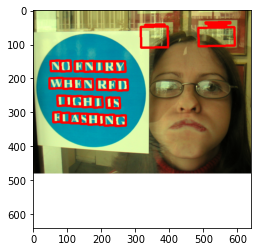

In [74]:
# Fine tune the detector

data_dir = '.'

import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf

import keras_ocr

dataset = keras_ocr.datasets.get_icdar_2013_detector_dataset(
    cache_dir='.',
    skip_illegible=False
)

train, validation = sklearn.model_selection.train_test_split(
    dataset, train_size=0.8, random_state=42
)
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.Affine(
    scale=(1.0, 1.2),
    rotate=(-5, 5)
    ),
    imgaug.augmenters.GaussianBlur(sigma=(0, 0.5)),
    imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2)
])
generator_kwargs = {'width': 640, 'height': 640}
training_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=train,
    augmenter=augmenter,
    **generator_kwargs
)
validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=validation,
    **generator_kwargs
)

image, lines, confidence = next(training_image_generator)
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)

In [75]:
# build detector
detector = keras_ocr.detection.Detector()

batch_size = 1
training_generator, validation_generator = [
    detector.get_batch_generator(
        image_generator=image_generator, batch_size=batch_size
    ) for image_generator in
    [training_image_generator, validation_image_generator]
]
detector.model.fit_generator(
    generator=training_generator,
    steps_per_epoch=math.ceil(len(train) / batch_size),
    epochs=1,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(os.path.join(data_dir, 'detector_icdar2013.csv')),
        tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(data_dir, 'detector_icdar2013.h5'))
    ],
    validation_data=validation_generator,
    validation_steps=math.ceil(len(validation) / batch_size)
)

detector.model.load_weights(os.path.join(data_dir, 'detector_icdar2013.h5'))
# changed epochs from 1000 to 1 for testing

Looking for /Users/j/.keras-ocr/craft_mlt_25k.h5


  warnings.warn('`Model.fit_generator` is deprecated and '

  warnings.warn(



183/183 [==============================] - 1940s 11s/step - loss: 0.0142 - val_loss: 0.0134


In [376]:
#detector = keras_ocr.detection.Detector(weights='clovaai_general')

#  alphabet = string.digits + string.ascii_letters + '.'
# recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))

recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()
recognizer.model.load_weights(os.path.join(data_dir, 'recognizer_mydata_v2.h5'))

Looking for /Users/j/.keras-ocr/crnn_kurapan.h5


In [380]:
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()
recognizer.model.load_weights('./recognizer_borndigital.h5')

Looking for /Users/j/.keras-ocr/crnn_kurapan.h5


In [65]:
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

text: 5


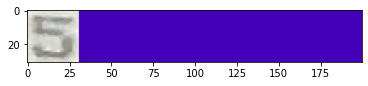

In [90]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)

In [94]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_mydata_v2.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_mydata_v2.csv')
]
recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=1,
)

# changed epochs from 1000 (original) to 250 (33 training hours to 8hrs)

  warnings.warn('`Model.fit_generator` is deprecated and '



60/60 [==============================] - 223s 4s/step - loss: 6.5930 - val_loss: 2.0093


  warnings.warn('Custom mask layers require a config and must override '



In [96]:
recognizer.model.load_weights('./recognizer_mydata_v2.h5')

In [379]:
image_filepath, _, actual = test_labels[2]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

NameError: name 'test_labels' is not defined

Looking for /Users/j/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/j/.keras-ocr/crnn_kurapan.h5


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


(7,)


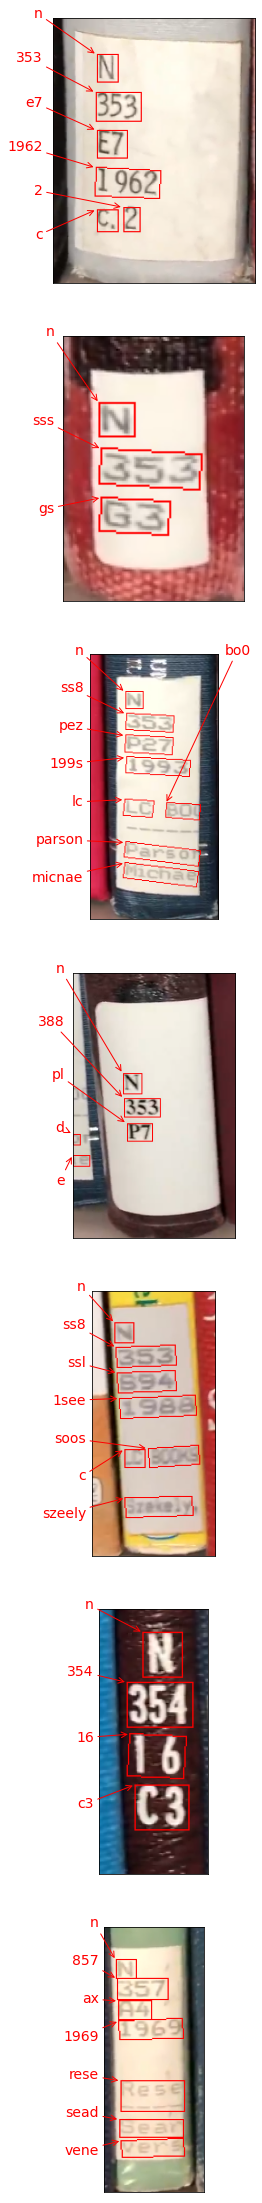

In [17]:
def drawAnnotations(image, predictions, ax=None):
    """Draw text annotations onto image.

    Args:
        image: The image on which to draw
        predictions: The predictions as provided by `pipeline.recognize`.
        ax: A matplotlib axis on which to draw.
    """
    if ax is None:
        _, ax = plt.subplots()
    img_written = keras_ocr.tools.drawBoxes(image=image, thickness=1, boxes=predictions, boxes_format="predictions")
    ax.imshow(img_written)
    predictions = sorted(predictions, key=lambda p: p[1][:, 1].min())
    left = []
    right = []
    for word, box in predictions:
        if box[:, 0].min() < image.shape[1] / 2:
            left.append((word, box))
        else:
            right.append((word, box))
    ax.set_yticks([])
    ax.set_xticks([])
    for side, group in zip(["left", "right"], [left, right]):
        for index, (text, box) in enumerate(group):
            y = 1 - (index / len(group))
            xy = box[0] / np.array([image.shape[1], image.shape[0]])
            xy[1] = 1 - xy[1]
            ax.annotate(
                text=text,
                xy=xy,
                xytext=(-0.05 if side == "left" else 1.05, y),
                xycoords="axes fraction",
                arrowprops={"arrowstyle": "->", "color": "r"},
                color="r",
                fontsize=14,
                horizontalalignment="right" if side == "left" else "left",
            )
    return ax, img_written 

detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()
#recognizer.model.load_weights('./recognizer_mydata_v2.h5')
pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)

# List of three example images
spine_labels = ['/users/j/downloads/cap/spine_labels/1.png',
               '/users/j/downloads/cap/spine_labels/2.png',
               '/users/j/downloads/cap/spine_labels/3.png',
               '/users/j/downloads/cap/spine_labels/4.png',
               '/users/j/downloads/cap/spine_labels/5.png',
               '/users/j/downloads/cap/spine_labels/6.png',
               '/users/j/downloads/cap/spine_labels/7.png'] 
images = [keras_ocr.tools.read(img) for img in spine_labels]

#Print shape...
print(np.shape(images))

# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
prediction_groups = pipeline.recognize(images)

# Plot the predictions
axs_num = 0
fig, axs = plt.subplots(nrows=len(images), figsize=(40, 40))
for ax, image, predictions in zip(axs, images, prediction_groups):
    drawAnnotations(image=image, predictions=predictions, ax=ax)
    extent = axs[axs_num].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('../Resources/Testing/Outputs/keras/ax_figure_expanded_new_keras'+str(axs_num)+'.png', bbox_inches=extent.expanded(.15, 1.3), facecolor=(1, 1, 1, 1), edgecolor='none')
    axs_num+=1
#fig.savefig('../Resources/Testing/Outputs/keras/keras-ocr_output.png')

In [161]:
import time
start = time.time()
prediction_groups = pipeline.recognize(['/users/j/downloads/cap/spine_labels/5.png'])
end = time.time()
print(end - start)

1.0995378494262695


In [151]:
for i in prediction_groups[0]:
    print(i[0])

n
33
z
190z
z
c


In [4]:
# COMPLETE END TO END TRAINING
# from https://keras-ocr.readthedocs.io/

import zipfile
import datetime
import string
import glob
import math
import os

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

data_dir = '.'

alphabet = string.digits + string.ascii_letters + '!?. '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir
)
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

text_generator = keras_ocr.data_generation.get_text_generator(alphabet=alphabet)
print('The first generated text is:', next(text_generator))

def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

Looking for ./fonts.zip
Unzipping fonts ZIP file.


Filtering fonts.: 100%|████████████████████| 2734/2734 [01:04<00:00, 42.27it/s]


Looking for ./backgrounds.zip
The first generated text is: Any activity climatological low in the field via the strong weak.


In [5]:
image_generators = [
    keras_ocr.data_generation.get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(12, 24, 36),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(0, 0)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

The first generated validation image (below) contains: Can
t Garza along Bayshore


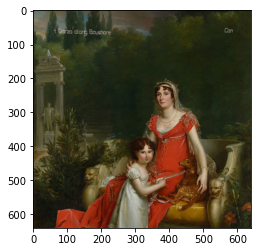

In [6]:
image, lines = next(image_generators[1])
# See what the first validation image looks like.
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

In [ ]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizer.compile()
for layer in recognizer.backbone.layers:
    layer.trainable = False
    
    detector_batch_size = 1
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]
detector.model.fit_generator(
    generator=detection_train_generator,
    steps_per_epoch=math.ceil(len(background_splits[0]) / detector_batch_size),
    epochs=5,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / detector_batch_size)
)

Looking for /Users/j/.keras-ocr/craft_mlt_25k.h5


2021-12-08 05:25:20.920494: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /Users/j/.keras-ocr/crnn_kurapan_notop.h5


/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/anaconda3/lib/python3.8/site-packages/keras_ocr/tools.py:504: RuntimeWarning: invalid value encountered in float_scalars
  rotation = np.arctan((tl[0] - bl[0]) / (tl[1] - bl[1]))
2021-12-08 05:25:38.167412: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
 48/830 [>.............................] - ETA: 2:16:39 - loss: 0.0074

In [ ]:
max_length = 10
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)
           
recognition_batch_size = 8
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')
recognition_train_generator, recognition_val_generator, recogntion_test_generator = [
    recognizer.get_batch_generator(
      image_generator=image_generator,
      batch_size=recognition_batch_size,
      lowercase=True
    ) for image_generator in recognition_image_generators
]
recognizer.training_model.fit_generator(
    generator=recognition_train_generator,
    epochs=5,
    steps_per_epoch=math.ceil(len(background_splits[0]) / recognition_batch_size),
    callbacks=[
      tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=25),
      tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
      tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / recognition_batch_size),
    workers=0
)


In [ ]:
pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)
image, lines = next(image_generators[0])
predictions = pipeline.recognize(images=[image])[0]
drawn = keras_ocr.tools.drawBoxes(
    image=image, boxes=predictions, boxes_format='predictions'
)
print(
    'Actual:', '\n'.join([' '.join([character for _, character in line]) for line in lines]),
    'Predicted:', [text for text, box in predictions])
plt.imshow(drawn)

# changed BOTH epochs from 1000 (original) to 1

In [4]:
detector = keras_ocr.detection.Detector()
detector.model.load_weights('./detector_2021-12-08T00:57:09.688856.h5')

recognizer = keras_ocr.recognition.Recognizer()
recognizer.model.load_weights('./recognizer_2021-12-08.h5') #, by_name=True, skip_mismatch=True)
recognizer.compile()
#recognizer.model.load_weights('./recognizer_borndigital.h5')

pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)

Looking for /Users/j/.keras-ocr/craft_mlt_25k.h5


2021-12-08 05:01:07.720214: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Looking for /Users/j/.keras-ocr/crnn_kurapan.h5


ValueError: Cannot assign to variable fc_12/kernel:0 due to variable shape (256, 37) and value shape (256, 41) are incompatible

In [64]:
recognizer.model.summary()

Model: "model_206"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_145 (InputLayer)          [(None, 31, 200, 1)] 0                                            
__________________________________________________________________________________________________
permute_28 (Permute)            (None, 200, 31, 1)   0           input_145[0][0]                  
__________________________________________________________________________________________________
lambda_112 (Lambda)             (None, 200, 31, 1)   0           permute_28[0][0]                 
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 200, 31, 64)  640         lambda_112[0][0]                 
__________________________________________________________________________________________

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(7,)


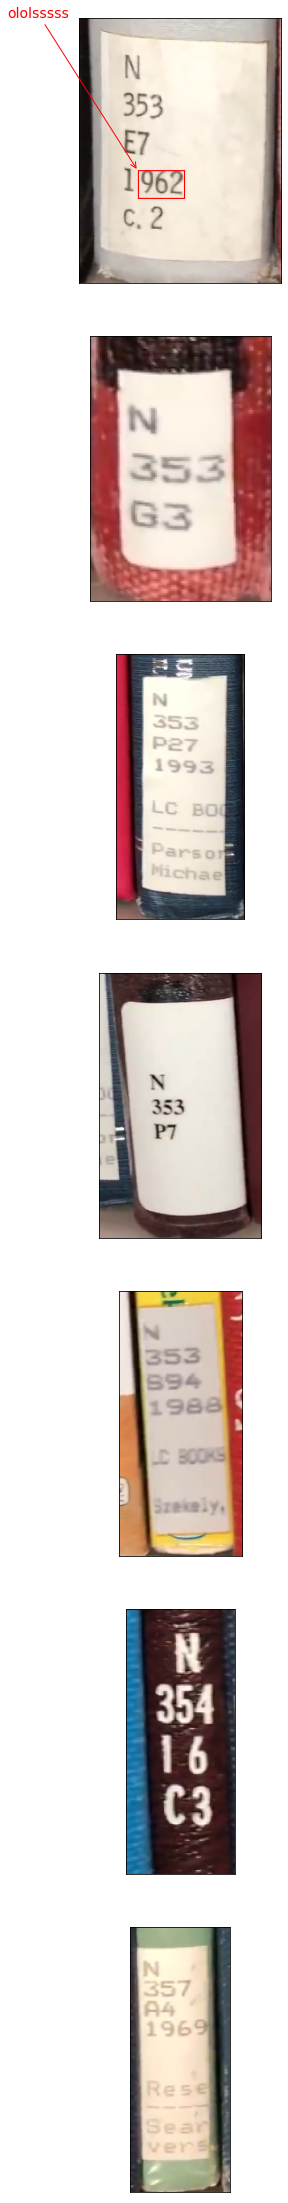

In [65]:
# Drawing detections on tutorial-trained detector and recognizer (without fine-tuning)

def drawAnnotations(image, predictions, ax=None):
    """Draw text annotations onto image.

    Args:
        image: The image on which to draw
        predictions: The predictions as provided by `pipeline.recognize`.
        ax: A matplotlib axis on which to draw.
    """
    if ax is None:
        _, ax = plt.subplots()
    img_written = keras_ocr.tools.drawBoxes(image=image, thickness=1, boxes=predictions, boxes_format="predictions")
    ax.imshow(img_written)
    predictions = sorted(predictions, key=lambda p: p[1][:, 1].min())
    left = []
    right = []
    for word, box in predictions:
        if box[:, 0].min() < image.shape[1] / 2:
            left.append((word, box))
        else:
            right.append((word, box))
    ax.set_yticks([])
    ax.set_xticks([])
    for side, group in zip(["left", "right"], [left, right]):
        for index, (text, box) in enumerate(group):
            y = 1 - (index / len(group))
            xy = box[0] / np.array([image.shape[1], image.shape[0]])
            xy[1] = 1 - xy[1]
            ax.annotate(
                text=text,
                xy=xy,
                xytext=(-0.05 if side == "left" else 1.05, y),
                xycoords="axes fraction",
                arrowprops={"arrowstyle": "->", "color": "r"},
                color="r",
                fontsize=14,
                horizontalalignment="right" if side == "left" else "left",
            )
    return ax, img_written 
'''
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()
recognizer.model.load_weights('./recognizer_mydata_v2.h5')
pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)
'''


'''detector = keras_ocr.detection.Detector(weights='clovaai_general')
detector.model.load_weights('./detector_2021-12-08T00:57:09.688856.h5')
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()
recognizer.model.load_weights('./recognizer_2021-12-08T02:45:28.333701.h5')

pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)'''

pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)

# List of three example images
spine_labels = ['/users/j/downloads/cap/spine_labels/1.png',
               '/users/j/downloads/cap/spine_labels/2.png',
               '/users/j/downloads/cap/spine_labels/3.png',
               '/users/j/downloads/cap/spine_labels/4.png',
               '/users/j/downloads/cap/spine_labels/5.png',
               '/users/j/downloads/cap/spine_labels/6.png',
               '/users/j/downloads/cap/spine_labels/7.png'] 
images = [keras_ocr.tools.read(img) for img in spine_labels]

#Print shape...
print(np.shape(images))

# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
prediction_groups = pipeline.recognize(images)

# Plot the predictions
axs_num = 0
fig, axs = plt.subplots(nrows=len(images), figsize=(40, 40))
for ax, image, predictions in zip(axs, images, prediction_groups):
    drawAnnotations(image=image, predictions=predictions, ax=ax)
    #extent = axs[axs_num].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig('../Resources/Testing/Outputs/keras/ax_figure_expanded_new_keras'+str(axs_num)+'.png', bbox_inches=extent.expanded(.15, 1.3), facecolor=(1, 1, 1, 1), edgecolor='none')
    #axs_num+=1

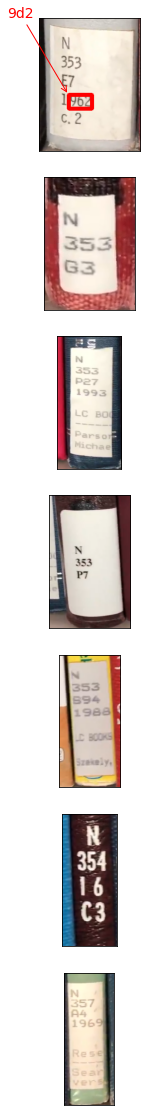

In [47]:
# Using a pretrained model

import matplotlib.pyplot as plt

import keras_ocr

# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

# Get a set of three example images
images = ['/users/j/downloads/cap/spine_labels/1.png',
               '/users/j/downloads/cap/spine_labels/2.png',
               '/users/j/downloads/cap/spine_labels/3.png',
               '/users/j/downloads/cap/spine_labels/4.png',
               '/users/j/downloads/cap/spine_labels/5.png',
               '/users/j/downloads/cap/spine_labels/6.png',
               '/users/j/downloads/cap/spine_labels/7.png'
         ]

# List of three example images
spine_labels = ['/users/j/downloads/cap/spine_labels/1.png',
               '/users/j/downloads/cap/spine_labels/2.png',
               '/users/j/downloads/cap/spine_labels/3.png',
               '/users/j/downloads/cap/spine_labels/4.png',
               '/users/j/downloads/cap/spine_labels/5.png',
               '/users/j/downloads/cap/spine_labels/6.png',
               '/users/j/downloads/cap/spine_labels/7.png'] 
images = [keras_ocr.tools.read(img) for img in spine_labels]

# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
prediction_groups = pipeline.recognize(images)

# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

FPS : 60.0
Total frames: 442
Looking for /Users/j/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/j/.keras-ocr/crnn_kurapan.h5


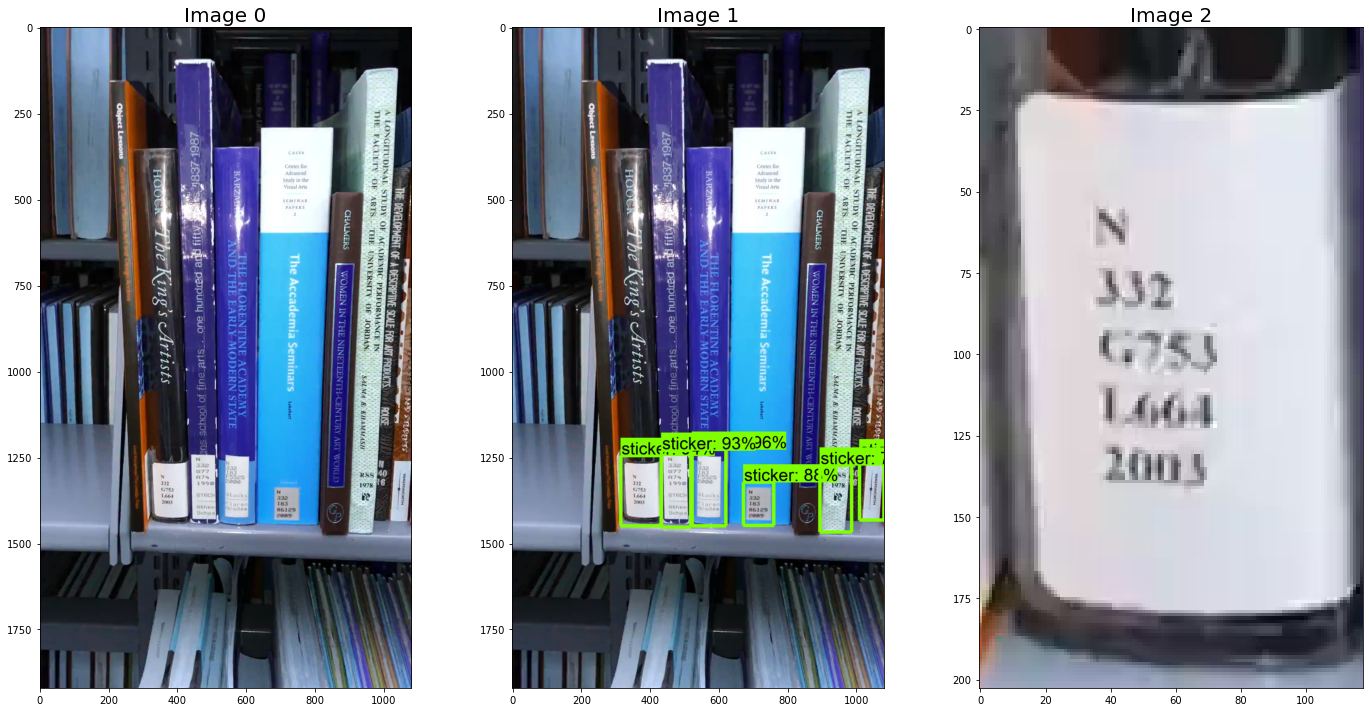

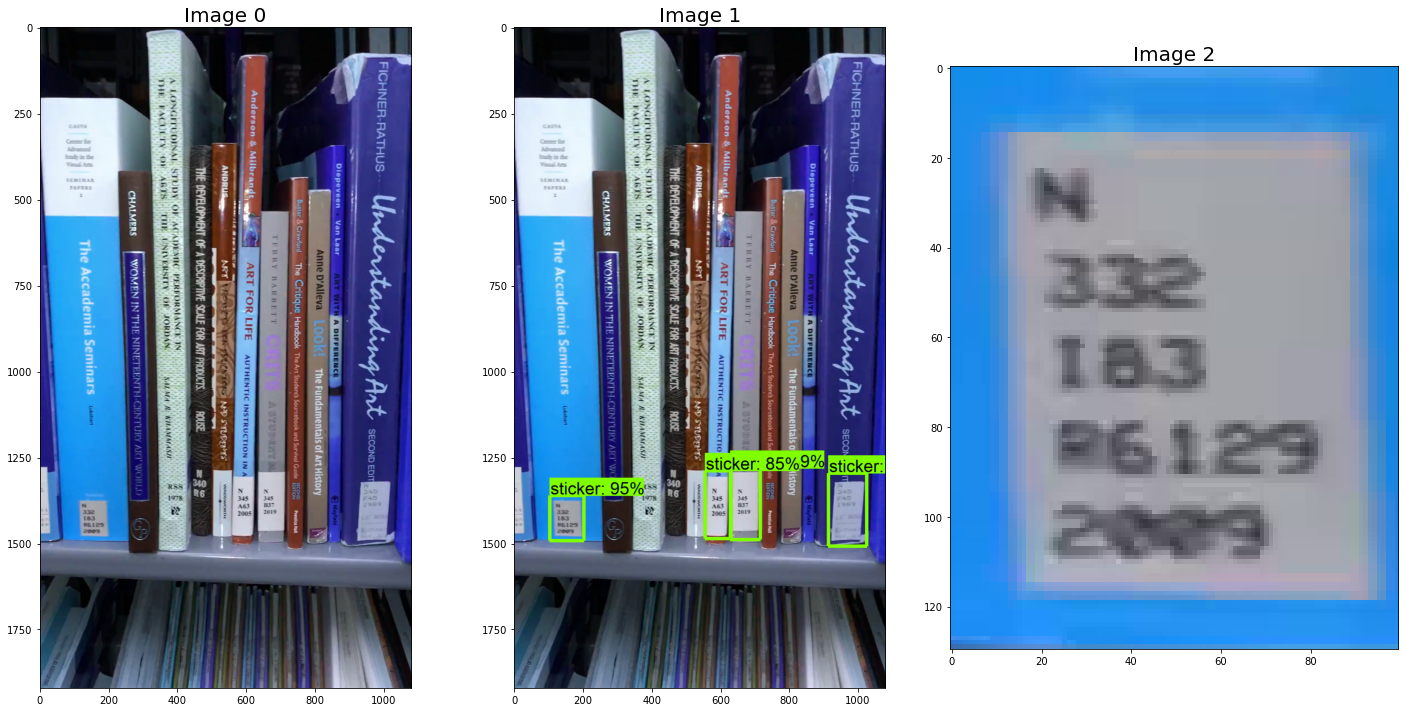

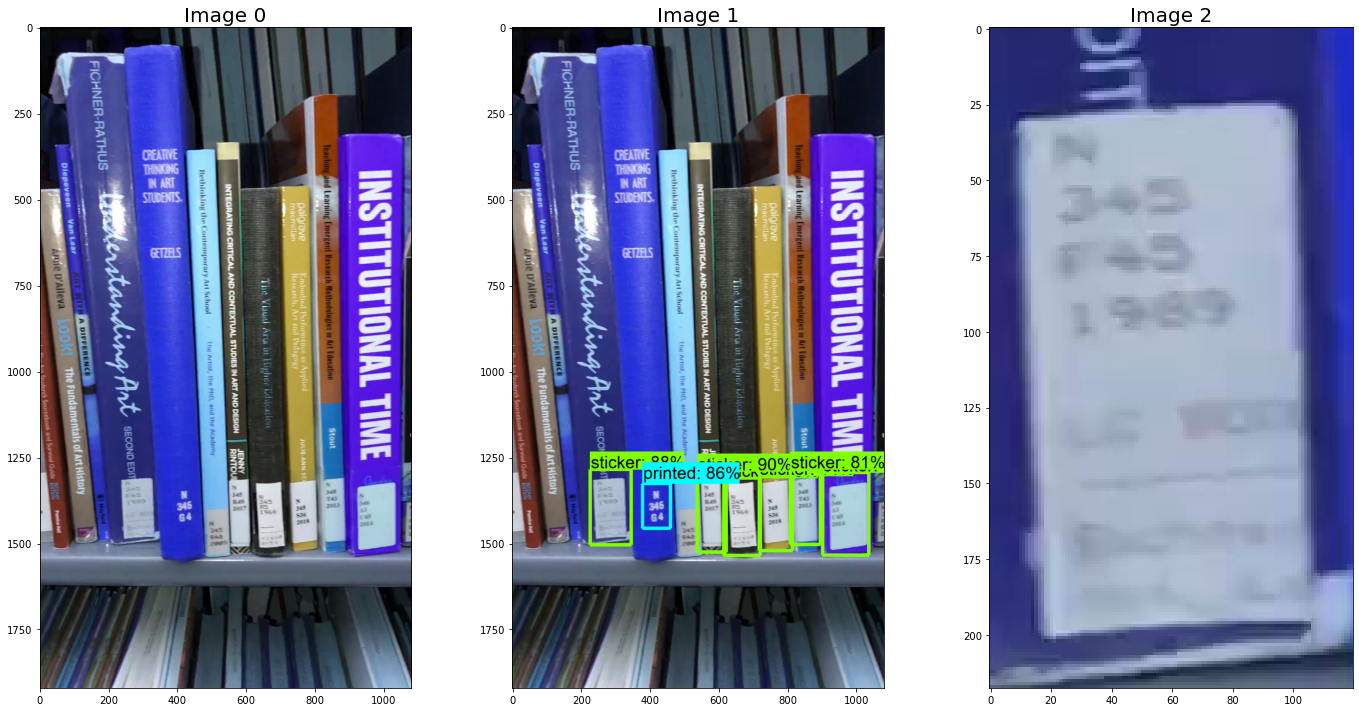

In [22]:
def detectOutOfOrderBooks(frame, keras_pipeline):
    # takes a cv2_frame and returns the detected image with colors over out-of-order book
    
    # get bounding-box sticker detections
    detected, original, bounding_boxes = detectFrame(frame)
    
    #get bounding box locations
    boxlist = [pltImShowBox(original, bounding_boxes, i) for i in range(len(bounding_boxes))]
    
    # read sticker text into library call number format using lib `pycallnum`
    prediction_groups = keras_pipeline.recognize([i for i in boxlist])
    
    boxes_to_color_red = []
    for i, box_num in enumerate(range(len(prediction_groups)-1)):
        curr_label = ' '.join([detection[0] for detection in prediction_groups[box_num]])
        next_label = ' '.join([detection[0] for detection in prediction_groups[i+1]])

        try:
            curr_label = pycn.callnumber(curr_label)
            next_label = pycn.callnumber(next_label)
            curr_label.classification
            next_label.classification
            print('Comparing valid labels of current: {} and next: {}'.format(curr_label, next_label))
            if (curr_label > next_label):
                boxes_to_color_red.append(box_num)
        # call number must be malformed if both `.classification` calls fail, so the label is colored red
        except:
            #print('No classification for malformed call_num: "{}"'.format(call_num))
            boxes_to_color_red.append(box_num)  
    
    return boxes_to_color_red, detected, original, bounding_boxes #e.g. [1,2,5]
    
def hightlightOutOfOrderLabels(img, bounding_boxes, bad_boxes):
    # returns image with transparent red squares over bad labels
    image = img
    bbox = bounding_boxes
    
    overlay = image.copy()
    alpha = 0.9  # higher number means more opaque

    for i in bad_boxes:
        boxNumToShow = i
        y1 = bbox[list(bbox.keys())[boxNumToShow]]['y1']
        y2 = bbox[list(bbox.keys())[boxNumToShow]]['y2']
        x1 = bbox[list(bbox.keys())[boxNumToShow]]['x1']
        x2 = bbox[list(bbox.keys())[boxNumToShow]]['x2']

        x = x1
        y = y1
        w = x2-x1
        h = y2-y1

        #x, y, w, h = 10, 10, 500, 500  # Rectangle parameters
        cv2.rectangle(overlay, (x, y), (x+w, y+h), (0, 0, 200), -1)  # A filled rectangle (BGR color red)
        # Following line overlays transparent rectangle over the image
        cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, overlay)
        #cv2.imwrite('/Users/j/Downloads/red_boxes/overlay_from_highlight_func.png', overlay)
    return overlay


vid1 = '/Users/j/Google Drive/MSD Utah/Fall 2021/Capstone/Resources/Testing/Inputs/vid1.mov'
cap = cv2.VideoCapture(vid1)
print("FPS : {0}".format(cap.get(cv2.CAP_PROP_FPS)))
print("Total frames: {}".format(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))

jump_ahead_to_frame = 0
bbox = ''
frame1 = ''
detected_img1 = ''
# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
keras_pipeline = keras_ocr.pipeline.Pipeline()
img_count = 0
while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        labels_to_color_red, detected_img, original_img, bounding_boxes = detectOutOfOrderBooks(frame, keras_pipeline)
        img_with_bad_labels = hightlightOutOfOrderLabels(detected_img, bounding_boxes, labels_to_color_red)
        detected_img1 = detected_img
        frame1 = frame
        # cv2.imwrite('/Users/j/Downloads/red_boxes/vid2/frame{}.png'.format(str(img_count).zfill(6)), img_with_bad_labels)
        img_count += 1
#         fig, ax = plt.subplots(figsize=(20, 10))
#         ax.imshow(img_with_bad_labels, interpolation='nearest')
#         plt.tight_layout()

        show_image_list(list_images=[original_img, detected_img, pltImShowBox(original_img, bounding_boxes, 0)], 
                #list_titles=['original', 'gradx', 'grady', 'mag_binary', 'dir_binary'],
                num_cols=3,
                figsize=(20, 10),
                grid=False, # overlay a grid
                title_fontsize=20)
        
        jump_ahead_to_frame += 120 # only look at every 3rd frame (in a 60FPS video)
        cap.set(cv2.CAP_PROP_POS_FRAMES, jump_ahead_to_frame)
        
        if jump_ahead_to_frame >= 360: # at 20FPS, this is 10 seconds
            break
    else:
        cap.release()
        break

In [10]:
def saveToMovie():
    #os.system("ffmpeg -r 5 -i /Users/j/Downloads/red_boxes/frame%06d.png -vcodec mpeg4 -y /Users/j/Downloads/red_boxes/movie.mp4")
    os.system("ffmpeg -r 20 -f image2 -s 1920x1080 -i /Users/j/Downloads/red_boxes/vid2/frame%06d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p /Users/j/Downloads/red_boxes/vid3/movie3.mp4")
    # ffmpeg -r 60 -f image2 -s 1920x1080 -i pic%04d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p test.mp4
saveToMovie()

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.5 (clang-1205.0.22.9)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enable-videotoolbox
  libavutil      5